In [1]:
#Importation du fichier de données
import os
os.chdir('/Users/learegazzetti/Documents/Cours/M1_Info/Data_Mining_M1_Info/Projet')

import pandas
df = pandas.read_csv('data_avec_etiquettes.txt', sep = '\t')

In [2]:
#Recodage de la variable cible pour le scoring
import numpy
df['V200_recod'] = numpy.where(df['V200']=='m16', 'positive', 'negative')
#On ne garde pas la variable cible avec les 23 modalités
df = df.iloc[:,df.columns!="V200"]

In [3]:
#Création des dummies variables pour les modalités des variables quantitatives (V160,V161 et V162)

#liste des variables qualitatives
lstQuali = [var for var in df.columns[:-1] if df[var].dtype == numpy.object_]
#Recodage des variables qualitatives
dfQualiEncoded = pandas.get_dummies(df[lstQuali],drop_first=True)
#liste des variables quantitatives
lstQuanti = [var for var in df.columns[:-1] if df[var].dtype != numpy.object_]
#réunir dummies et quantitatives dans le même data frame
dfNew = pandas.concat([dfQualiEncoded,df[lstQuanti]],axis=1)
#rajouter la variable cible
dfNew['V200_recod'] = df['V200_recod']

In [4]:
#Subdivision des données en échantillon test (test) et échantillon d'apprentissage (train)
import sklearn
from sklearn import model_selection
 
train,test = model_selection.train_test_split(dfNew,test_size = round(dfNew.shape[0]*30/100),random_state=0) 
#test_size=30% de 494021 
#random_state fixé à 0 pour pouvoir reproduire l'approche 

print(train.shape,test.shape)

(345815, 274) (148206, 274)


In [5]:
#Proportions d'observatitons positives et négatives dans les deux sous-échantillons
print(train.V200_recod.value_counts())
print(test.V200_recod.value_counts())

negative    345086
positive       729
Name: V200_recod, dtype: int64
negative    147895
positive       311
Name: V200_recod, dtype: int64


In [6]:
#Isole les variables prédictives (x) de la variable cible (y) pour chaque échantillon (test et train)

x_train=train.iloc[:,0:dfNew.shape[1]-1]
y_train=train.iloc[:,dfNew.shape[1]-1]
print(y_train.shape, x_train.shape)

x_test=test.iloc[:,0:dfNew.shape[1]-1]
y_test=test.iloc[:,dfNew.shape[1]-1]
print(y_test.shape, x_test.shape)

(345815,) (345815, 273)
(148206,) (148206, 273)


In [7]:
#Première sélection de variables : pour enlever les colonnes de constantes
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold()
selector.fit(x_train)

VarianceThreshold()

In [8]:
#Liste des variables constantes
print(x_train.columns[selector.variances_ == 0])

Index(['V178', 'V179'], dtype='object')


In [9]:
#Réduction de la base d'apprentissage aux variables sélectionnées
x_train = x_train.iloc[:,selector.get_support()] 
print(x_train.shape) # 271 variables restantes



(345815, 271)


In [10]:
#réduction de la base test aux mêmes variables
x_test = x_test.iloc[:,selector.get_support()] 
print(x_test.shape)

(148206, 271)


In [11]:
#classe Régression Logistique
from sklearn.linear_model import LogisticRegression 
#création d'une instance de la classe
lr = LogisticRegression(solver='liblinear', multi_class='ovr')
#modélisation sur les données d'apprentissage
lr.fit(x_train,y_train)



LogisticRegression(multi_class='ovr', solver='liblinear')

In [12]:
#algorithme de sélection de var.
from sklearn.feature_selection import SelectFromModel 
selecteur = SelectFromModel(estimator=lr)

In [13]:
#lancer la recherche
sol = selecteur.fit(x_train,y_train)

In [14]:
#liste des variables sélectionnées
print(sol.get_support())

[ True  True False False  True False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True  True  True  True  True
  True  True False False False False  True False False False False False
  True False  True  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False  True
  True False False False False False False False False False False False
  True  True False False  True False False False False False  True False
 False False False False  True False False  True  True False False False
 False  True False False False False  True False  T

In [17]:
#réduction de la base d'app. aux var. sélectionnées
#en utilisant le filtre booléen sol.get_support()
x_new_train = x_train.iloc[:,sol.get_support()] 
print(x_new_train.shape) # 42 variables restantes

(345815, 69)


In [18]:
#réduction de la base test aux mêmes variables
x_new_test = x_test.iloc[:,sol.get_support()] 
print(x_new_test.shape)

(148206, 69)


In [19]:
#Liste des variables sélectionnées
col = x_train.iloc[:,sol.get_support()]
variables_importantes = pandas.DataFrame(col.columns)
print(variables_importantes)

           0
0    V160_m2
1    V160_m3
2   V161_m12
3   V161_m20
4   V161_m39
..       ...
64      V195
65      V196
66      V197
67      V198
68      V199

[69 rows x 1 columns]


In [20]:
#Export de la liste des variables qui contribuent pour le déploiement après
variables_importantes.to_csv('variables_importantes_scoring.txt', header=False, index=False)

In [21]:
#modélisation sur les données d'apprentissage réduites
modele = lr.fit(x_new_train,y_train)

In [22]:
pred = modele.predict(x_new_test) 

#taux d'erreur
from sklearn import metrics
err = 1.0 - metrics.accuracy_score(y_test,pred)
print(err)  #0.00013494730307817004

0.00013494730307817004


In [40]:
#affichage des coefficients
print(pandas.DataFrame({"var":x_new_train.columns,"coef":lr.coef_[0]}))
#et de la constante
print(lr.intercept_)

         var      coef
0    V160_m2  0.448881
1    V160_m3 -1.716388
2   V161_m12  0.109859
3   V161_m20 -2.279058
4   V161_m39 -2.964152
..       ...       ...
64      V195 -1.086432
65      V196 -2.745613
66      V197 -0.030499
67      V198 -1.542917
68      V199  1.428344

[69 rows x 2 columns]
[-1.8299586]


In [23]:
#calcul des probas d'affectation sur ech. test
probas = modele.predict_proba(x_new_test) 
print(probas)

[[1.00000000e+000 4.44957199e-013]
 [1.00000000e+000 7.74991711e-013]
 [1.00000000e+000 1.21284829e-242]
 ...
 [1.00000000e+000 2.94785996e-242]
 [1.00000000e+000 2.97440474e-241]
 [1.00000000e+000 2.47743666e-242]]


In [24]:
#score de 'presence'
score = probas[:,1]
print(score)

[4.44957199e-013 7.74991711e-013 1.21284829e-242 ... 2.94785996e-242
 2.97440474e-241 2.47743666e-242]


In [25]:
#transf. en 0/1 de Y_test
pos = pandas.get_dummies(y_test).values
print(pos)

[[1 0]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [1 0]]


In [26]:
#on ne récupère que la 2è colonne (indice 1)
pos = pos[:,1]
print(pos)

[0 0 0 ... 0 0 0]


In [27]:
#nombre total de positif
import numpy
npos = numpy.sum(pos)
print(npos)

311


In [28]:
#index pour tri selon le score croissant
index = numpy.argsort(score) 
index = index[::-1]
print(index)

[ 37170  51891  11355 ...  70193 145560  35203]


In [29]:
sort_pos = pos[index] #somme cumulée
print(sort_pos)

[1 1 1 ... 0 0 0]


In [30]:
cpos = numpy.cumsum(sort_pos)
print(cpos)

[  1   2   3 ... 311 311 311]


In [31]:
rappel = cpos/npos   #rappel
print(rappel)

[0.00321543 0.00643087 0.0096463  ... 1.         1.         1.        ]


In [32]:
#nb. obs ech.test
n = y_test.shape[0] 
#taille de cible – séquence de valeurs de 1 à n+1 avec un pas de 1
taille = numpy.arange(start=1,stop=148207,step=1) 
#passer en proportion
taille = taille / n
print(taille)

[6.74736515e-06 1.34947303e-05 2.02420955e-05 ... 9.99986505e-01
 9.99993253e-01 1.00000000e+00]


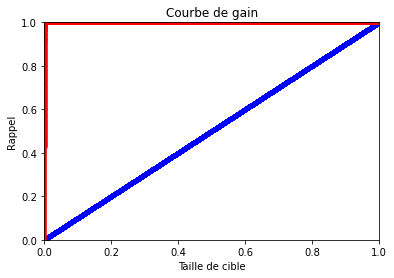

In [33]:
#graphique avec matplotlib
import matplotlib.pyplot as plt
#titre et en-têtes
plt.title('Courbe de gain') 
plt.xlabel('Taille de cible') 
plt.ylabel('Rappel')
#limites en abscisse et ordonnée
plt.xlim(0,1) 
plt.ylim(0,1)
#astuce pour tracer la diagonale
plt.scatter(taille,taille,marker='.',color='blue') 
#insertion du couple (taille, rappel)
plt.scatter(taille,rappel,marker='.',color='red')
#affichage
plt.show()

In [34]:
#recherche des 10000 / 148206 en se basant sur la taille
numpy.argwhere(taille <= 10000/148206)


array([[   0],
       [   1],
       [   2],
       ...,
       [9997],
       [9998],
       [9999]])

In [35]:
#indice = 9999, ce qui est logique
#quelle est le rappel correspondant
prop_pos = rappel[9999]
print(prop_pos)

1.0


In [36]:
#on multiple par le nombre de positifs
print(prop_pos * npos)

311.0


SAUVEGARDE DU MODELE

In [37]:
#librairie pour sauvegarde du modèle
import pickle

#référence du fichier - ouverture en écriture binaire
f = open("modele_scoring.sav","wb")



In [38]:
#sauvegarde dans le fichier référencé
pickle.dump(lr, f)

In [39]:
#fichier qu'il faut fermer
f.close()